In [1]:


import lettuce as lt
from lettuce import D3Q19, UnitConversion
import csv
from lettuce import Observable
from lettuce.ext._force.adaptive_force import AdaptiveForce
from lettuce.ext._boundary.wallfunction import WallFunction
from lettuce.ext._reporter.observable_reporter import GlobalMeanUXReporter, WallQuantities
from lettuce.ext._stencil.d3q19 import D3Q19


In [2]:
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import numpy as np
import torch

parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=100)
parser.add_argument("--tmax", type=int, default=0)
parser.add_argument("--Re", type=int, default=180)
parser.add_argument("--collision_operator", type=str, default="Smag")
parser.add_argument("--Precision", type=str, default="Double")
parser.add_argument("--Mach", type=float, default=0.1)
parser.add_argument("--h", type=int, default=10, help="Halbe Kanalhöhe in LU")
parser.add_argument("--bbtype", type=str, default="wallfunction", choices=["halfway", "fullway", "wallfunction", "freeslip"],
                    help="Typ der Bounce-Back-Randbedingung")

args, unknown = parser.parse_known_args()
args = vars(args)

print("ICH FUNKTIONIERE MIT PULLEN")



# Einheiten und Auflösung
h = args["h"]                      # Kanalhalbhöhe in LU
res_y = 2 * h                     # y: volle Kanalhöhe
res_x = int(2*np.pi * h)
res_z = int(np.pi * h)

# Restliche Parameter
Re = args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision = args["Precision"]
collision_operator = args["collision_operator"]
Mach = args["Mach"]
bbtype = args["bbtype"]
h = args["h"]

# Präzision
if Precision == "Single":
    dtype = torch.float32
elif Precision == "Double":
    dtype = torch.float64
elif Precision == "Half":
    dtype = torch.float16


ICH FUNKTIONIERE MIT PULLEN


In [3]:
context = lt.Context(device=torch.device('cuda:0') if torch.cuda
                     .is_available() else torch.device('cpu'),
                     dtype=dtype, use_native = False)

flow = lt.ChannelFlow3D(
    context = context,
    resolution=h,
    reynolds_number=Re**(8/7)*(8/0.073)**(4/7),
    stencil = D3Q19(),
    mach_number=Mach,
    bbtype=bbtype
)

shape = flow.resolution
mask_bottom = torch.zeros(shape, dtype=torch.bool, device=context.device)
mask_bottom[:, 0, :] = True
mask_top = torch.zeros(shape, dtype=torch.bool, device=context.device)
mask_top[:, -1, :] = True
mask_force = torch.ones(shape, dtype=torch.bool, device=context.device)
mask_force[:, 0, :] = False
mask_force[:, -1, :] = False

global_mean_ux_reporter = GlobalMeanUXReporter(flow = flow)

wq_bottom = WallQuantities(mask = mask_bottom, wall = "bottom", flow=flow, boundary=flow.boundaries[0], context = context)
wq_top = WallQuantities(mask = mask_top, wall = "top", flow=flow, boundary=flow.boundaries[1], context = context)

adaptive_force_instance = AdaptiveForce(
    flow=flow,
    context = context,
    target_u_m_lu=flow.units.convert_velocity_to_lu(1),
    wall_bottom=flow.boundaries[0],
    wall_top=flow.boundaries[1],
    global_ux_reporter=global_mean_ux_reporter,
    base_lbm_tau_lu=flow.units.relaxation_parameter_lu,
    mask = mask_force
)

if collision_operator == "BGK":

    collision = lt.BGKCollision(tau=flow.units.relaxation_parameter_lu, force=adaptive_force_instance)

elif collision_operator == "Smag":
    
    collision = lt.SmagorinskyCollision(tau=flow.units.relaxation_parameter_lu, force=adaptive_force_instance)

elif collision_operator == "MRT":
    
    collision = lt.MRTCollision(tau=flow.units.relaxation_parameter_lu, force=adaptive_force_instance)

simulation = lt.Simulation(flow=flow, collision=collision, reporter = [])

simulation.reporter.append(lt.ObservableReporter(global_mean_ux_reporter, interval=1, out=None))
simulation.reporter.append(lt.ObservableReporter(wq_bottom, interval=100, out=None))
simulation.reporter.append(lt.ObservableReporter(wq_top, interval=100, out=None))

steps = int(flow.units.convert_time_to_lu(tmax))
vtk_reporter = lt.VTKReporter(interval=max(1, int(steps/100)), filename_base=basedir + "/output_h20_t30")
simulation.reporter.append(vtk_reporter)

mlups = simulation.step(num_steps=steps)

wq_top_arr = np.array(simulation.reporter[2].out)
wq_bottom_arr = np.array(simulation.reporter[1].out)
ux_mean_arr = np.array(simulation.reporter[0].out)

with open(csvdir + 'uxmean.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(ux_mean_arr)
with open(csvdir + 'WallQuantitiesTop.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(wq_top_arr)
with open(csvdir + 'WallQuantitiesBottom.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(wq_bottom_arr)


[62, 20, 31] 19


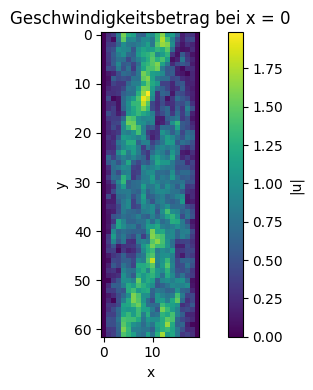

In [7]:
import matplotlib.pyplot as plt
# 💡 Schritt 1: u holen und Betrag berechnen
u = flow.units.convert_velocity_to_pu(flow.u())  # [3, Nx, Ny, Nz]
u_mag = torch.sqrt(u[0]**2+u[2]**2)  # [Nx, Ny, Nz]

# 💡 Schritt 2: Slice bei x = 0 extrahieren
slice_2d = u_mag[:, :, 0]  # [Ny, Nz]

# 💡 Schritt 3: Plotten
plt.figure(figsize=(6, 4))
plt.imshow(slice_2d.cpu().numpy())
plt.colorbar(label='|u|')
plt.title('Geschwindigkeitsbetrag bei x = 0')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()


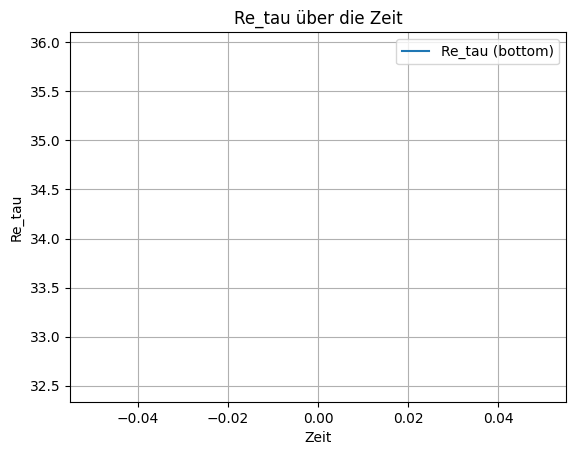

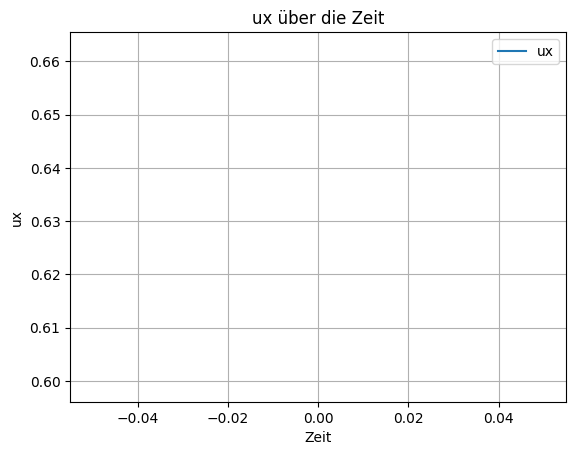

In [5]:



print(wq_bottom)
# Beispiel: Daten laden
data = (wq_bottom_arr+wq_top_arr)/2
time = data[:, 1]
re_tau = data[:, 4]
y_plus = data[:, 3]


plt.figure()
plt.plot(time, re_tau, label="Re_tau (bottom)")
plt.xlabel("Zeit")
plt.ylabel("Re_tau")
plt.legend()
plt.grid()
plt.title("Re_tau über die Zeit")
plt.savefig(csvdir + "retau.pdf")

plt.show()

plt.figure()
plt.plot(ux_mean_arr[:,1], flow.units.convert_velocity_to_pu(ux_mean_arr[:,2]), label="ux")
plt.xlabel("Zeit")
plt.ylabel("ux")
plt.legend()
plt.grid()
plt.title("ux über die Zeit")
plt.savefig(csvdir + "yplus.pdf")
plt.show()


In [6]:
print(u.shape)

torch.Size([3, 62, 20, 31])
